# Assignment 2 - Question 3
The objective of this assignment is to get you familiarize with  the  problem  of  `Dimensionality Reduction`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified. Libraries allowed (Numpy, matplotlib)

## Datasets 
- The IIIT-CFW is database for the cartoon faces in the wild. The dataset contains 8928 annotated cartoon faces of famous personalities of the world with varying profession. Additional 1000 real faces of the public figure to study cross modal retrieval tasks, such as, Photo2Cartoon retrieval. Ref - https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces
- We have sub sampled the following data for this assignment - Cartoon faces of 8 subjects and approx. 100 images for each subject. 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q3.ipynb`.

In [44]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [45]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from numpy import linalg as LA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Load Data

In [46]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [47]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [48]:
import zipfile
with zipfile.ZipFile('IIIT-CFW.zip', 'r') as zip_ref:
    zip_ref.extractall('images')

In [49]:
dirpath = './images/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [50]:
print(X.shape)
input_data=X.reshape((*X.shape[:1],-1),order="C")
print(input_data.shape)

(672, 32, 32, 3)
(672, 3072)


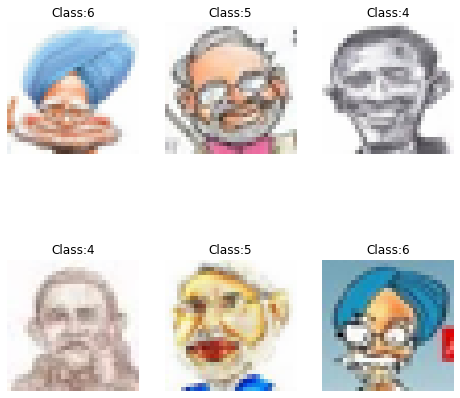

In [51]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

## Dimensionality Reduction
- Plot eigen spectrum for the data.

Percentage of variance preserved is defined as the fraction of eigen values used. As we include more principal components to describe the data, the percentage of variances preserved under the dimensionality reduction increases. 

- Plot the percentage of variances vs the number of principal components to validate the above statement.
- Try visualizing these eigen vectors. Comment on what these ghost faces represent 
- Try reconstructing images with your choice of number of principal components and visualize the reconstructed image.

Let's define reconstruction error as the frobenius norm of the difference between original and reconstructed image. 

- Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
- Using the two dominant principal values, plot the data with colors showing the labels. What do you observe?


#### Write a function that gives eigen values and eigen vectors given data

In [52]:
# write function
def standardizing_input(input_data):
  mean_value=np.mean(input_data,axis=0)
  std_value=np.std(input_data,axis=0)

  print(input_data.shape)
  standardized_input_data=np.subtract(input_data,mean_value,dtype=np.float64)
  standardized_input_data=np.divide(standardized_input_data,std_value,dtype=np.float64)
  print(standardized_input_data.shape)
  return standardized_input_data

def cov_matrix_std_data(standardized_input_data):
  covariance_matrix=np.matmul(standardized_input_data.T,standardized_input_data)
  print(covariance_matrix.shape)
  return covariance_matrix

def get_eigens(covariance_matrix):
  values, vectors = LA.eigh(covariance_matrix)
  # sorted_indexes = np.argsort(-1*values)
  sorted_indexes = np.argsort(values)[::-1]
  values = values[sorted_indexes]
  vectors = vectors[:,sorted_indexes]
  return values,vectors


In [53]:
cov=np.cov(input_data.T)
cov.shape

(3072, 3072)

In [54]:
# standardized_input_data=standardizing_input(input_data)
# cov=cov_matrix_std_data(standardized_input_data)
cov=np.cov(input_data.T)
values,vectors=get_eigens(cov)

#### Compute eigen values and plot eigen value spectrum

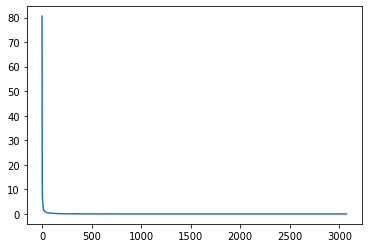

In [55]:
# eigen values and spectrum
plt.plot(values)

#### Plot the percentage of variances vs the number of principal components

Text(0, 0.5, 'variance')

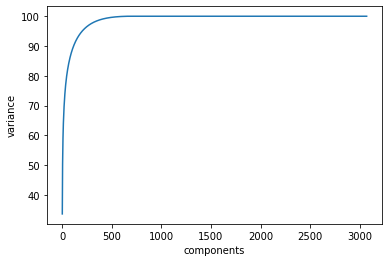

In [56]:
# plot variance vs components
cummulative_sum=np.cumsum(values)
total_sum=np.sum(values)
cummulative_sum=cummulative_sum/total_sum
plt.plot(cummulative_sum*100)
plt.xlabel("components")
plt.ylabel("variance")

#### Visualize eigen faces(eigen vectors)

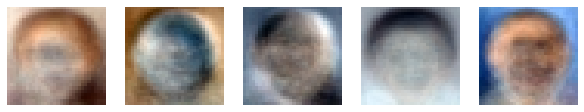

In [57]:
# Use the below sample code to visualize the eigen faces and reconstructed images (can write your own function as well)

def plot(image,H,W,C,indices):
    #indices = [randrange(100)+1 for i in range(5)]
    pl = np.reshape(image.T,(-1,H,W,C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()

indices = [randrange(12)+1 for i in range(5)]
plot(vectors,H,W,C, indices)


#### Reconstruction 

In [58]:
def get_num_of_components(eigen_values,required_percent):
  cummulative_sum=np.cumsum(eigen_values)
  total_sum=np.sum(values)
  cummulative_sum=cummulative_sum/total_sum
  percent=cummulative_sum*100
  for i in range(len(percent)):
    if percent[i]>=required_percent:
      # print(i+1)
      return i+1

In [59]:
n_components=get_num_of_components(values,90)
useful_vectors=vectors[:,:n_components]
useful_vectors.shape


(3072, 115)

In [60]:
# reconstruction
# 672x3072 100x3072^T 672X100 
# 
def reconstruction(input_data,useful_vectors):
  return np.matmul(useful_vectors.T,input_data.T).T
truncated_input=reconstruction(input_data,useful_vectors)
truncated_input.shape

(672, 115)

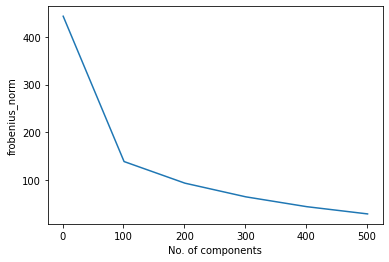

In [62]:
no_of_comps = []
frobenius_norm = []

for i in range(1,502,100):
    no_of_comps.append(i)
    eigenvector_subset=vectors[:,:i]
    X_reduced=np.dot(eigenvector_subset.T,input_data.T).T
    recons_images = np.dot(X_reduced,eigenvector_subset.T)
    a=recons_images.reshape((-1,H*W*C))
    b=X.reshape((-1,H*W*C))
    diff = b-a
    frobenius_norm.append(np.linalg.norm(diff))
plt.xlabel("No. of components")
plt.ylabel("frobenius_norm")
plt.plot(no_of_comps,frobenius_norm)


#### Plot data in 2D

(672, 2)


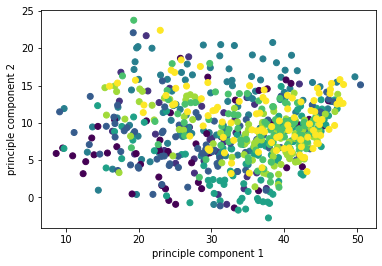

In [63]:
# (672x3072)*(3072x2)=(672x2)
reduced_x=np.matmul(input_data,vectors[:,:2])
print(reduced_x.shape)
plt.xlabel("principle component 1")
plt.ylabel("principle component 2")
plt.scatter(reduced_x[:,0],reduced_x[:,1],c=y)

After plotting the data in 2D using the top two principle components, it is observed that the data is  scattered, clusters are not formed. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


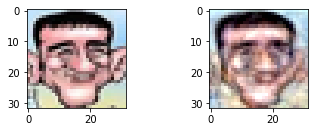

In [64]:
def plot_image_comparison(input_data,truncated_input,index):
  image_point=np.matmul(useful_vectors,truncated_input[index])
  fig = plt.figure()
  ax1 = fig.add_subplot(2,2,1)
  ax1.imshow(np.reshape(input_data[index],(H,W,C)))
  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(np.reshape(image_point,(H,W,C)))
  plt.show()

plot_image_comparison(input_data,truncated_input,33)


## Lets analyze the principal components classwise
- Visualize dominant eigen faces of each of the classes.
- Print the number of principal components required to retain 90% variance for each of the classes and for the entire dataset
- Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Example output:
```
Number of principal components required for 90% reconstruction of the:
Entire Dataset = 10 
Amitabhbachan = 10
AamirKhan = 10
...
```

In [65]:
# Load data again
X,y = load_data(dirpath)
print(X.shape)
input_data=X.reshape((*X.shape[:1],-1),order="C")
print(input_data.shape)

class_wise_dict=dict()
class_wise_eigen_values=dict()
class_wise_eigen_vectors=dict()
class_wise_n_components=dict()
for i in range(len(y)):
  if(class_wise_dict.get(y[i],0)==0):
    class_wise_dict[y[i]]=list()
  class_wise_dict[y[i]].append(input_data[i])
count=0
for i,j in class_wise_dict.items():
  j=np.array(j)
  class_wise_dict[i]=j  
  count+=len(j)


Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672, 32, 32, 3)
(672, 3072)


#### Number of principal components required to retain 90% variance for each of the classes and for the entire dataset

In [69]:
# components required
print("Number of principal components required for 90% reconstruction of the:")
for i,j in class_wise_dict.items():
  cov=np.cov(j.T)
  values,vectors=get_eigens(cov)
  class_wise_eigen_values[i]=values
  class_wise_eigen_vectors[i]=vectors
  class_n_components=get_num_of_components(values,90)
  print("class Name:",i," is ",class_n_components)
  class_wise_n_components[i]=class_n_components
print("Entire data set",n_components)

Number of principal components required for 90% reconstruction of the:
class Name: 1  is  24
class Name: 3  is  36
class Name: 0  is  21
class Name: 4  is  43
class Name: 2  is  28
class Name: 6  is  50
class Name: 5  is  57
class Name: 7  is  44
Entire data set 115


#### Visualize dominant eigen faces of each of the classes

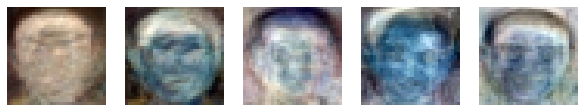

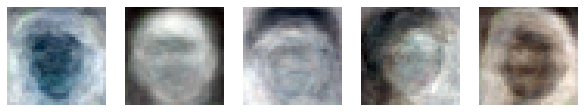

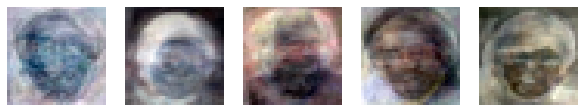

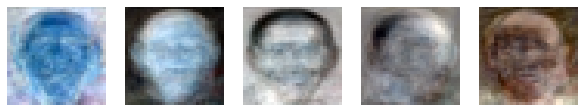

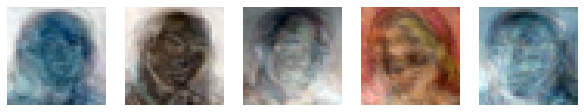

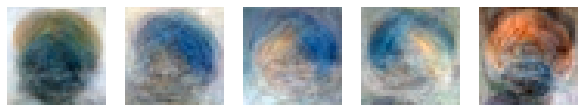

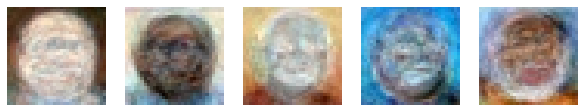

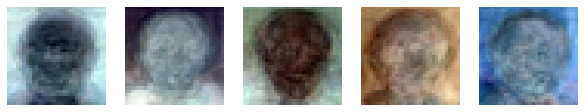

In [70]:
# visualize
for i,j in class_wise_eigen_vectors.items():
  indices = [i for i in range(5)]
  plot(j,H,W,C, indices)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


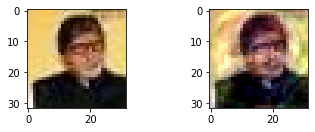

In [71]:
useful_vectors=class_wise_eigen_vectors[0][:,:class_wise_n_components[0]]
truncated_input=reconstruction(class_wise_dict[0],useful_vectors)
plot_image_comparison(class_wise_dict[0],truncated_input,0)

#### Analysis : Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

- The number of principle components required to obtain more than 90% variance is different for the entire data set and for each class . 
- Because when PCA is performed on entire data it preserves the data considering all classes. 
- When PCA is performed classwise it preserves the important features belongs to that class only.

## Linear Regression (continued)
1. Perform linear regression on below datapoints
2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

Note :- Can use inbuilt functions for Linear Regression and PCA for this question

In [72]:
# datapoints
X,_ = load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
print(label.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672,)


linear regression for entire dataset

Using PCA linear regression for entire dataset (changing no of components)

plot the score for different no of components


Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


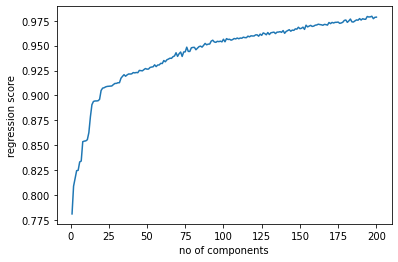

In [73]:
# datapoints
X,_ = load_data(dirpath)
X = X.reshape((X.shape[0],-1))

#loading the data again to get the linear regression
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
label = np.reshape(label,(X.shape[0],-1))

#storing the components and score in the lists
percent = []
score = []
#finding the score vs data graph for the first 200 components
for i in range(1,201):
    percent.append(i)
    pca = PCA(n_components=i)
    transformed_data = pca.fit_transform(X)

    #fitting the data
    reg = LinearRegression().fit(transformed_data, label)
    reg_score = reg.score(transformed_data, label)
    score.append(reg_score)

#plotting the graph
plt.xlabel("no of components")
plt.ylabel("regression score")
plt.plot(percent,score)

plt.show()

As the number of components increases, R2 score increases. 
R2 score is a goodness-of-fit measure for linear regression models. Adding more components gives a better model.